#  Panorama

Have you ever wondered what goes on under the hood when you take a picture in panorama mode? Multiple computer vision techniques are involved in creating a simple panorama. While a lot more goes into creating a good panorama, the basic principle is to align the concerned images using a **homography** and '**stitch**'ing them intelligently so that you do not see the seams. 

# Creating Simple Panoramas

We will learn how to create simple panoramas using the techniques we have learned so far. You should be warned that Panorama images can be disturbing if gone wrong! Have a look at these [**Panorama fails**](https://mashable.com/2013/05/19/panoramic-photo-fails/#eAuBAPpXBiqa) and enjoy!

# Overview

The technique we will use is often called “feature based” image alignment because in this technique a sparse set of features are detected in one image and matched with the features in the other image. A transformation ( Homography ) is then calculated based on these matched features that warps one image on to the other. We have already seen in the previous chapter how we can use Homography between two images to align one image w.r.t another. 

Once, the second image is aligned with respect to the first image, we can simply stitch the first image with the aligned second image to get a Panorama.

We will use these two images to create a panorama 

| <center> <a href="https://i.imgur.com/hb30eU3.jpg"><img src = "https://i.imgur.com/hb30eU3.jpg" width=400/></a></center> | <center> <a href="https://i.imgur.com/dj3hSao.jpg"><img src = "https://i.imgur.com/dj3hSao.jpg" width=400/></a></center> |
| -------- | -------- | 
| <center>Image 1</center>     | <center>Image 2</center>     |

# Creating Panorama in OpenCV
Creating a panorama for 2 images consists of the following steps : 
1. Find Keypoints and Descriptors for both images.
1. Find Corresponding points by matching their Descriptors.
1. Align second image with respect to first image using Homography.
1. Warp the second image using Perspective Transformation.
1. Combine the first image with the warped image to get the Panorama.

We have given code snippets for understanding the theory better. It is advised to download the code and run it instead of copying from below.

## Step 1 : Find Keypoints and Descriptors ?
In many Computer Vision applications, we often need to identify interesting stable points in an image. These points are called keypoints or feature points. In the previous chapter, we had manually marked four points at the corner of the book for perspective correction. But in the case of Panoramas, we will need to find many points and that should be done automatically using some algorithm. There are several keypoint detectors implemented in OpenCV ( e.g. SIFT, SURF, and ORB).

We will use the ORB feature detector because it was co-invented by my former labmate Vincent Rabaud. Just kidding! We will use ORB because SIFT and SURF are patented and if you want to use it in a real-world application, you need to pay a licensing fee. ORB is fast, accurate and license-free!

ORB stands for Oriented FAST and Rotated BRIEF. Let’s see what FAST and BRIEF mean.

A feature point detector has two parts

1. **Locator**: This identifies points on the image that are stable under image transformations like translation (shift), scale (increase / decrease in size), and rotation. The locator finds the $(x, y)$ coordinates of such points. The locator used by the ORB detector is called [FAST](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_fast/py_fast.html).
2. **Descriptor**: The locator in the above step only tells us the location of interesting points. The second part of the feature detector is the descriptor which encodes the appearance of the point so that we can distinguish one feature point from the other. The descriptor evaluated at a feature point is simply an array of numbers. Ideally, the same physical point in two images should have the same descriptor. ORB uses a modified version of the feature descriptor called [BRISK](https://www.robots.ox.ac.uk/~vgg/rg/papers/brisk.pdf).

### Code
 
We first convert the BGR images to Gray and then use the OpenCV functions of ORB to compute the keypoints and Descriptors.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

In [8]:
# Read reference image
imageFile1 = DATA_PATH + "images/scene/scene1.jpg"
print("Reading First image : ", imageFile1)
im1 = cv2.imread(imageFile1, cv2.IMREAD_COLOR)

Reading First image :  ../data/images/scene/scene1.jpg


In [9]:
# Read image to be aligned
imageFile2 = DATA_PATH + "images/scene/scene3.jpg"
print("Reading Second Image : ", imageFile2);
im2 = cv2.imread(imageFile2, cv2.IMREAD_COLOR)

Reading Second Image :  ../data/images/scene/scene3.jpg


In [10]:
# Convert images to grayscale
im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

In [11]:
im1Keypoints = np.array([])
im1Keypoints = cv2.drawKeypoints(im1, keypoints1, im1Keypoints, color=(0,0,255),flags=0)
print("Saving Image with Keypoints")
cv2.imwrite("keypoints.jpg", im1Keypoints)

Saving Image with Keypoints


True

Text(0.5, 1.0, 'Keypoints obtained from the ORB detector')

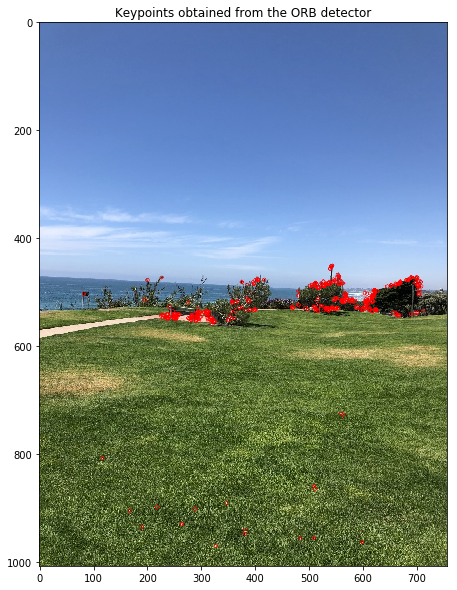

In [12]:
plt.imshow(im1Keypoints[:,:,::-1])
plt.title("Keypoints obtained from the ORB detector")

## Step 2 : Find matching corresponding points
The homography that relates the two images can be calculated only if we know corresponding features in the two images. So a matching algorithm is used to find which features in one image match features in the other image. For this purpose, the descriptor of every feature in one image is compared to the descriptor of every feature in the second image to find good matches. We use hamming distance as a measure of similarity. 

It should be noted that we have many incorrect matches and thefore we will need to use a robust method to calculate homography.

### Code
For matching the descriptors we will use the `DescriptorMatcher` present in OpenCV to find the matching scores between descriptors in image1 and image2. 

The naming used in OpenCV for Descriptor Matcher is a bit unconventional. The Descriptor Matcher object ( matcher in our case ) takes in two arrays of descriptors. The first argument is named *queryDescriptor* and second is named *trainDescriptor*.

After getting the matches, we sort the scores in descending order and only take top 15% of the matches as corresponding points for the next step. 

In [13]:
# Match features.
matcher = cv2.DescriptorMatcher_create(
                cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

# Draw top matches
imMatches = cv2.drawMatches(im1, keypoints1,
                            im2, keypoints2, 
                            matches, None)

Text(0.5, 1.0, 'Matchings obtained from the descriptor matcher')

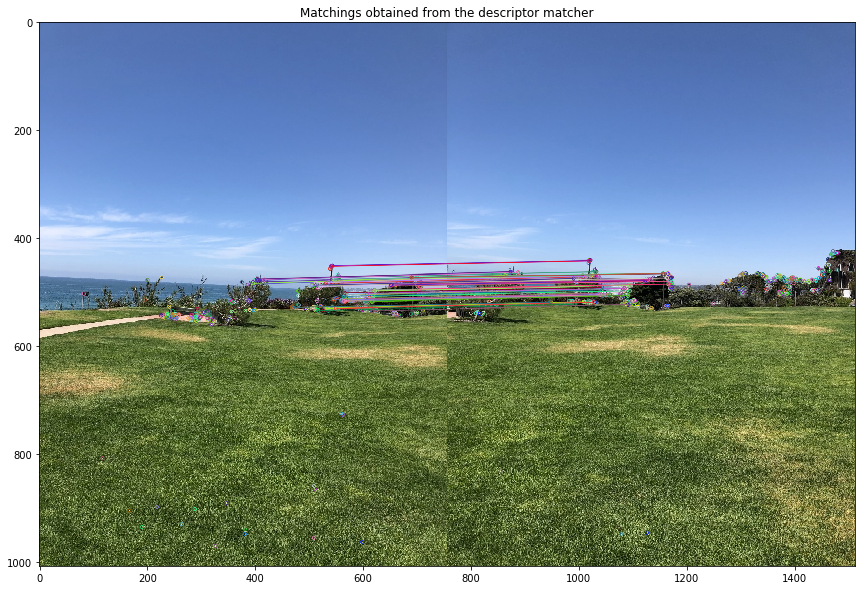

In [16]:
plt.figure(figsize=[15,10])
plt.imshow(imMatches[:,:,::-1])
plt.title("Matchings obtained from the descriptor matcher")

## Step 3 : Image Alignment using Homography

A homography can be computed when we have 4 or more corresponding points in two images. Automatic feature matching explained in the previous step does not always produce 100% accurate matches. It is not uncommon for 20-30% of the matches to be incorrect. Fortunately, the `findHomography` method utilizes a robust estimation technique called Random Sample Consensus ([RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus)) which produces the right result even in the presence of large number of bad matches. 

### Code

After matching is done, the output ( matches ) has the following attributes : 

* **`matches.distance`** - Distance between descriptors. Should be lower for better match.
* **`matches.trainIdx`** - Index of the descriptor in train descriptors
* **`matches.queryIdx`** - Index of the descriptor in query descriptors
* **`matches.imgIdx`** - Index of the train image.

To simplify things, the `queryIdx` corresponds to points in image1 and `trainIdx` corresponds to points in image2. We will create two lists - `points1` and `points2` from the matching points which will serve as the final set of correspoding points to be used in the `findHomography` function.

In [18]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
print("Homograhy matrix \n{}".format(h))

Homograhy matrix 
[[ 6.92265787e-01  3.49471159e-02  2.95739035e+02]
 [-2.19039226e-01  9.57373998e-01  4.58589735e+01]
 [-4.17109250e-04  4.60661656e-05  1.00000000e+00]]


## Step 4 : Warp Image
Once an accurate homography has been calculated, the transformation can be applied to all pixels in one image to map it to the other image. This is done using the `warpPerspective` function in OpenCV

### Code
While using the warp function, we should specify a different size of the output image(not the default size). Since we are stitching the images horizontally, we should specify the width of the output image to be sum of both images. We can keep the height to be same as any one of them.

In [19]:
# Use homography
im1Height, im1Width, channels = im1.shape
im2Height, im2Width, channels = im2.shape

im2Aligned = cv2.warpPerspective(im2, h, 
                            (im2Width + im1Width, im2Height))

Text(0.5, 1.0, 'Second image aligned to first image obtained using homography and warping')

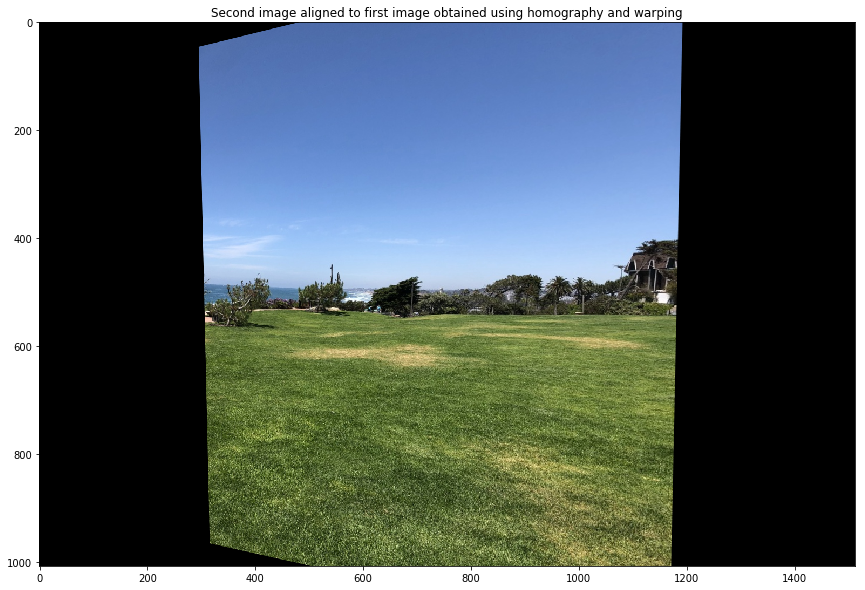

In [21]:
plt.figure(figsize=[15,10])
plt.imshow(im2Aligned[:,:,::-1])
plt.title("Second image aligned to first image obtained using homography and warping")

## Step 5 : Stitch Images
Finally we can simply concatenate the first image with the aligned second image and get the stitched image.

### Code
Since the second image is aligned with the first image, we can superimpose the first image on the output canvas to get the stitched image.

In [25]:
# Stitch Image 1 with aligned image 2
stitchedImage = np.copy(im2Aligned)
stitchedImage[0:im1Height,0:im1Width] = im1

Text(0.5, 1.0, 'Final Stitched Image')

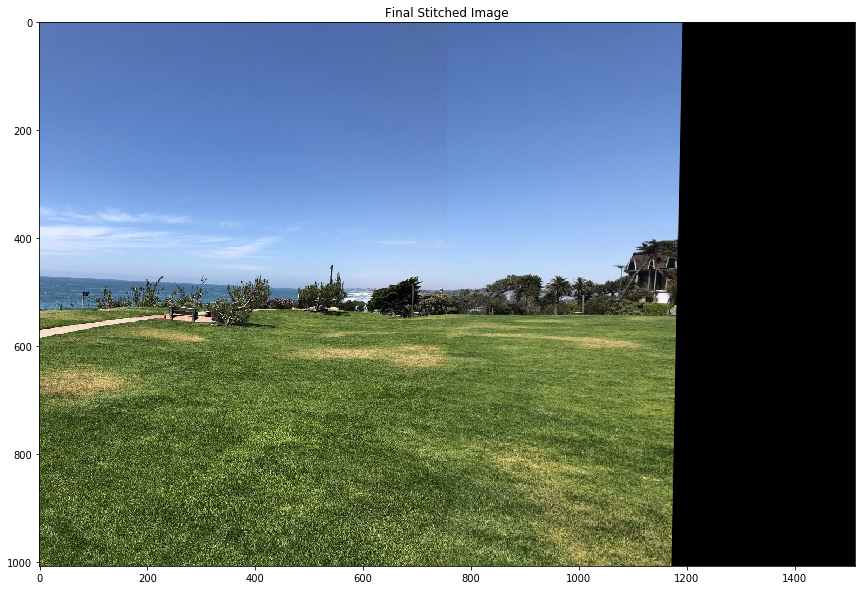

In [26]:
plt.figure(figsize=[15,10])
plt.imshow(stitchedImage[:,:,::-1])
plt.title("Final Stitched Image")

## Conclusion

This approach has some challenges : 
* There might be visible seams at the boundary of the two images. This is because of the variation in lighting / exposure between the two images.
* The lighting variation might also require some color correction as the two images might not blend well after stitching. 
* Difficult to extend to multiple images.

OpenCV has some utilities for creating Panoramas from a set of images. You will use it to create a panorama in the next assignment.